## Priprava dat
Rozdeleni dat na testovaci a trenovaco sety: 5krat aby byli co nejvic priblizene k sobe scaffoldy a 5krat aby byli co nejvic vzdalene od sebe scaffoldy

### Molpher
Pro Molpher budou vzaty jen uniaktni csk, takze pak kazdemu unaktnimu scaffoldu bude prirazena nejvic aktivnjesi sloucenina

### Other generators
Pro ostatni generatory budou vzaty vsechny slouceniny

# Library import

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.DataManip.Metric import GetTanimotoSimMat
from rdkit.Chem import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.ML.Cluster.Butina import EuclideanDist
from rdkit.ML.KNN.DistFunctions import TanimotoDist
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity

#descripts
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

from rdkit.Chem.Lipinski import NumAromaticHeterocycles
from rdkit.Chem.Lipinski import NumAliphaticRings
from rdkit.Chem.Lipinski import NumAromaticHeterocycles
from rdkit.Chem.Lipinski import NumAromaticRings

from rdkit.Chem.SaltRemover import SaltRemover

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import matthews_corrcoef

# plots
from matplotlib import pyplot
import seaborn

import itertools
from itertools import combinations

import numpy as np

from sklearn.metrics import jaccard_score

import os

## Loading data

In [2]:
#Funkce pro opravu problemu z SF5- prevede na CF3
#funkce od Wima
rxn = AllChem.ReactionFromSmarts\
('[*:0][S:1]([F:2])([F:3])([F:4])([F:5])[F:6]>>[*:0]-[C](-[F])(-[F])-[F].[*:1]([*:2])([*:3])([*:4])([*:5])[*:6]')
def MakeScaffoldGeneric_fixed(mol):
    for i in range(len(mol.GetSubstructMatches(Chem.MolFromSmiles("S(F)(F)(F)(F)F")))):
        products = rxn.RunReactants((mol,)) # tuple
        if len(products)>0:
            mol = products[0][0]
    return MakeScaffoldGeneric(mol)

In [3]:
def loading_processing_data(name_file,name):

    dff = pd.read_csv(f"{name_file}/{name}",header=None)
    dff.columns =['molregno', 'stand_type', 
                                    'pchembl_value', 'stand_value',
                                    'canonical_smiles', 'stand_inchi',
                                   'chembl_id', 'tid','pref_name']
            

    dff['scaffolds_csk'] = [1 for x in range(len(dff))]
    delete_element = 0
    for x in range(len(dff)):
                #print(x)
        remover = SaltRemover()
        res = remover.StripMol(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
        dff['canonical_smiles'][x] = Chem.MolToSmiles(res)
        if NumAromaticRings(Chem.MolFromSmiles(dff['canonical_smiles'][x])) == 0 and\
            NumAliphaticRings(Chem.MolFromSmiles(dff['canonical_smiles'][x])) == 0:
            print("Not contain ring")
            print(dff['canonical_smiles'][x])
            display(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
            dff = dff.drop([x])
            delete_element = 1
        if delete_element != 1:
            try:
                dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(\
                                         Chem.MolToSmiles(MakeScaffoldGeneric\
                                       (Chem.MolFromSmiles(dff['canonical_smiles'][x]))))
            except:
                print("Faild to create scaffold_csk")
                print("Index",x)
                print(dff['canonical_smiles'][x])
                display(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
                try:
                    mol = MakeScaffoldGeneric_fixed(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
                    display(mol)
                    dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(Chem.MolToSmiles(mol))
                    display(Chem.MolFromSmiles(MurckoScaffoldSmiles(Chem.MolToSmiles(mol))))
                except:
                    dff = dff.drop([x])
        delete_element = 0
        
    #dff['mfp'] = [AllChem.GetMorganFingerprintAsBitVect\
    #          (Chem.MolFromSmiles(x), 3, nBits = 2048) for x in  dff['scaffolds_csk']]
    dff['mfp'] = [(AllChem.GetMorganFingerprintAsBitVect\
                (Chem.MolFromSmiles(i),3, nBits=2048)) for i in dff['scaffolds_csk']]
      
    dff.reset_index(level=0, inplace=True)
    dff = dff.drop(columns = ['index'])
    return dff

In [12]:
nuclear_neaktiv = loading_processing_data('../../../postgres/qsar_data/sets/nuclear_neactive','25_pic50.csv')
#nuclear_neaktiv.to_csv('data/input_data/glucocor_recep.csv', index_label = False)
nuclear_neaktiv

/tmp/ipykernel_7448/149351612.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['canonical_smiles'][x] = Chem.MolToSmiles(res)
/tmp/ipykernel_7448/149351612.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(\


,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp
0,72705,IC50,7.40,40.0,COc1cccc2c1-c1ccc3c(c1[C@H]([C@H]1C=C(C)CCC1)O...,ZOUVODOOOFQPOC-DWXRJYCRSA-N,CHEMBL46325,25,Glucocorticoid receptor,C1CCC(C2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,27370,IC50,7.39,41.0,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,CHEMBL131,25,Glucocorticoid receptor,C1CCC2C(C1)CCC1C3CCCC3CCC21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,72755,IC50,7.92,12.0,COc1cccc2c1-c1ccc3c(c1C(C1C=CCC1)O2)C(C)=CC(C)...,BDZQBRNZPXXVRN-UHFFFAOYSA-N,CHEMBL47463,25,Glucocorticoid receptor,C1CCC2C(C1)CC(C1CCCC1)C1C3CCCCC3CCC21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,159249,IC50,7.25,56.0,COc1cccc2c1-c1ccc3c(c1C(c1cc(F)cc(F)c1)O2)C(C)...,WDWACRBIIZCRGV-UHFFFAOYSA-N,CHEMBL99123,25,Glucocorticoid receptor,C1CCC(C2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,72017,IC50,7.12,76.0,COc1cccc2c1-c1ccc3c(c1C(CC=C(F)F)O2)C(C)=CC(C)...,MACROYAVMFWALR-UHFFFAOYSA-N,CHEMBL50118,25,Glucocorticoid receptor,C1CCC2C(C1)CCC1C3CCCCC3CCC21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
7112,2559636,IC50,4.70,20000.0,CN1CCC(Oc2ccc(N3C(=S)N(c4cnc(C#N)c(C(F)(F)F)c4...,IZKSMIBPGSWAMO-UHFFFAOYSA-N,CHEMBL4865865,25,Glucocorticoid receptor,C1CCC(CC2CCC(C3CC(C4CCCCC4)CC34CCC4)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
7113,630886,IC50,4.54,29000.0,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,WXCXUHSOUPDCQV-UHFFFAOYSA-N,CHEMBL1082407,25,Glucocorticoid receptor,C1CCC(C2CCC(C3CCCCC3)C2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7114,2515140,IC50,7.58,26.0,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,KJELVKWMZHVGSD-KKSFZXQISA-N,CHEMBL4778549,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7115,2505900,IC50,8.70,2.0,Cc1ccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@...,BUPAQOQEQDIOPK-HJPURHCSSA-N,CHEMBL4758563,25,Glucocorticoid receptor,C1CCC(CCC2CCC3C(CCC3C3CCCCC3)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
nuclear_glucocor = loading_processing_data('../../../postgres/chembl_data/sets/nuclear_threshold_100nM_only_IC50','25_pic50.csv')
nuclear_glucocor

/tmp/ipykernel_7448/149351612.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['canonical_smiles'][x] = Chem.MolToSmiles(res)
/tmp/ipykernel_7448/149351612.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(\


,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp
0,557956,IC50,7.850000,14.00,C[C@H]1C[C@@H]2[C@H]3CCC4=CC(=O)C=C[C@@]4(C)[C...,PENABDXTRKXMIW-PZVMULSCSA-N,CHEMBL540936,25,Glucocorticoid receptor,C(CCCCCCC1CCC2C1CCC1C3CCCCC3CCC21)CCCCCC1CCC(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1607842,IC50,8.700000,2.00,CC[C@@H](Cn1ccc2ccccc21)NS(=O)(=O)c1c(N)cc(Cl)...,RXEIQMFFHIVGLD-AWEZNQCLSA-N,CHEMBL3093461,25,Glucocorticoid receptor,C1CCC(CCCCC2CCC3CCCCC23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1841315,IC50,7.380000,22.00,CC[C@@]12C[C@@](C)(O)[C@](O)(c3cccnc3)C[C@H]1C...,KDUBEHWLJHNXHQ-XUFNMVPLSA-N,CHEMBL3421877,25,Glucocorticoid receptor,C1CCC(C2CCC3C(CCC4CCCCC43)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2172692,IC50,7.010000,98.00,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)COc2ccc3c(cnn3-c3...,LREULHCSPAWXMB-IBGZPJMESA-N,CHEMBL3963321,25,Glucocorticoid receptor,C1CCC(CCCCCC2CCC3C(CCC3C3CCCCC3)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,325089,IC50,8.290000,5.10,C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...,GSBXDPQKEHNRQR-NPAAKHOSSA-N,CHEMBL363179,25,Glucocorticoid receptor,C1CCC(C2CCC3CC4C(CC5CCC6CCCCC65)CCCC4CC32)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
1151,1608876,IC50,8.080000,23.00,CCC(Cc1ccc(O)c2ccccc12)NS(=O)(=O)c1c(C)cc(C)cc1C,SFFRJYDGTHMNDH-UHFFFAOYSA-N,CHEMBL3094485,25,Glucocorticoid receptor,C1CCC(CCCCC2CCCC3CCCCC23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1152,111869,IC50,7.220000,60.00,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccccc1C#N,LTPXRZMBOFQRSK-UHFFFAOYSA-N,CHEMBL302758,25,Glucocorticoid receptor,C1CCC(CC(CC2CCCCC2)C2CCCCC2)CC1,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1153,1841317,IC50,8.333333,0.79,CC[C@@]12C[C@@](C)(O)[C@](O)(c3nccs3)C[C@H]1CC...,JJKRJVYCNAXILF-LMFCIFFHSA-N,CHEMBL3421879,25,Glucocorticoid receptor,C1CCC(C2CCC3C(CCC4CCCCC43)C2)C1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1154,2173873,IC50,8.810000,2.90,C[C@H](NC(=O)CO)[C@H](Oc1ccc2c(cnn2-c2ccc(F)cc...,WWWKKFOVJNHTTL-LMKMVOKYSA-N,CHEMBL3964502,25,Glucocorticoid receptor,C1CCC(CCC2CCC3C(CCC3C3CCCCC3)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
nuclear_ne = nuclear_neaktiv[nuclear_neaktiv.pchembl_value<6.5]

In [18]:
nuclear_ne = nuclear_ne[['canonical_smiles','pchembl_value']]
nuclear_ne = nuclear_ne.reset_index(drop=True)
nuclear_ne.to_csv('data/input_data/glucocor_recep_neaktiv.csv', index_label = False, header = False)

## Split data to clusters and then create test and train sets

In [6]:

def split_data_for_clusters_KMedoids(dff):
    df = dff.drop_duplicates(subset='scaffolds_csk', keep="first")
    df.reset_index(level=0, inplace=True)
    df = df.drop(columns = ['index'])
    
    fps = [x for x in df['mfp']]
    
    random_state = []
    for x in [1160]: 
        kmedoids = KMedoids(n_clusters=5,metric="jaccard", random_state = x, \
                            init='k-medoids++').fit(fps)
        labels = kmedoids.labels_
        
        if len(labels[labels==0]) >= 36 and len(labels[labels==1]) >= 36 and \
          len(labels[labels==2]) >= 36 and len(labels[labels==3]) >= 36 and \
          len(labels[labels==4]) >= 36 and len(labels[labels==0]) <= 48 and \
          len(labels[labels==1]) <= 48 and len(labels[labels==2]) <= 48 and \
          len(labels[labels==3]) <= 48 and len(labels[labels==4]) <= 48:
            print("Random_state: ", x)
            print(len(labels[labels==0]),len(labels[labels==1]),\
              len(labels[labels==2]),len(labels[labels==3]),len(labels[labels==4]))
            random_state.append(x)
    print(random_state)
    df['clusters'] = labels
    
    return df

In [7]:
df_clusters_gluco = split_data_for_clusters_KMedoids(nuclear_glucocor)
#df_clusters_gluco.to_csv('data/input_data/glucocor_recp_split_to_clusters_using_KMedoids.csv',index_label = False)
df_clusters_gluco.head()

Random_state:  1160
42 36 42 40 46
[1160]


/home/filv/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/filv/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp,clusters
0,557956,IC50,7.85,14.0,C[C@H]1C[C@@H]2[C@H]3CCC4=CC(=O)C=C[C@@]4(C)[C...,PENABDXTRKXMIW-PZVMULSCSA-N,CHEMBL540936,25,Glucocorticoid receptor,C(CCCCCCC1CCC2C1CCC1C3CCCCC3CCC21)CCCCCC1CCC(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,1607842,IC50,8.70,2.0,CC[C@@H](Cn1ccc2ccccc21)NS(=O)(=O)c1c(N)cc(Cl)...,RXEIQMFFHIVGLD-AWEZNQCLSA-N,CHEMBL3093461,25,Glucocorticoid receptor,C1CCC(CCCCC2CCC3CCCCC23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
2,1841315,IC50,7.38,22.0,CC[C@@]12C[C@@](C)(O)[C@](O)(c3cccnc3)C[C@H]1C...,KDUBEHWLJHNXHQ-XUFNMVPLSA-N,CHEMBL3421877,25,Glucocorticoid receptor,C1CCC(C2CCC3C(CCC4CCCCC43)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
3,2172692,IC50,7.01,98.0,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)COc2ccc3c(cnn3-c3...,LREULHCSPAWXMB-IBGZPJMESA-N,CHEMBL3963321,25,Glucocorticoid receptor,C1CCC(CCCCCC2CCC3C(CCC3C3CCCCC3)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,325089,IC50,8.29,5.1,C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...,GSBXDPQKEHNRQR-NPAAKHOSSA-N,CHEMBL363179,25,Glucocorticoid receptor,C1CCC(C2CCC3CC4C(CC5CCC6CCCCC65)CCCC4CC32)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2


In [8]:
df = df_clusters_gluco
print(len(df[df['clusters']==0]))
print(len(df[df['clusters']==1]))
print(len(df[df['clusters']==2]))
print(len(df[df['clusters']==3]))
print(len(df[df['clusters']==4]))

42
36
42
40
46


#### Data rozdeleni na shluky
Rozdeleli jsme jednou a ulozili a ted natahujeme ty ulozene data

In [16]:
a = []
b = []
for x in range(len(nuclear_glucocor)):
    canonica_smiles = nuclear_glucocor.loc[x]['canonical_smiles']
    if canonica_smiles not in a:
        a.append(canonica_smiles)
    else:
        b.append(canonica_smiles)

In [22]:
for x in b:
    a = nuclear_glucocor[nuclear_glucocor['canonical_smiles']==x]
    index = a.index
    first_index = index[0]
    nuclear_glucocor['pchembl_value'][first_index] = a.pchembl_value.mean()
    for y in index:
        if y != first_index:
            nuclear_glucocor = nuclear_glucocor.drop([y])


/tmp/ipykernel_10590/1311041638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclear_glucocor['pchembl_value'][first_index] = a.pchembl_value.mean()
/tmp/ipykernel_10590/1311041638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclear_glucocor['pchembl_value'][first_index] = a.pchembl_value.mean()


In [9]:
#nuclear_glucocor = pd.read_csv('data/input_data/glucocor_recep.csv')
nuclear_glucocor.head()
data_clusters_glucocor = pd.read_csv("data/input_data/glucocor_recp_split_to_clusters_using_KMedoids.csv")
data_clusters_glucocor.head()

,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp,clusters
0,557956,IC50,7.85,14.0,C[C@H]1C[C@@H]2[C@H]3CCC4=CC(=O)C=C[C@@]4(C)[C...,PENABDXTRKXMIW-PZVMULSCSA-N,CHEMBL540936,25,Glucocorticoid receptor,C(CCCCCCC1CCC2C1CCC1C3CCCCC3CCC21)CCCCCC1CCC(C...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0
1,1607842,IC50,8.70,2.0,CC[C@@H](Cn1ccc2ccccc21)NS(=O)(=O)c1c(N)cc(Cl)...,RXEIQMFFHIVGLD-AWEZNQCLSA-N,CHEMBL3093461,25,Glucocorticoid receptor,C1CCC(CCCCC2CCC3CCCCC23)CC1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4
2,1841315,IC50,7.38,22.0,CC[C@@]12C[C@@](C)(O)[C@](O)(c3cccnc3)C[C@H]1C...,KDUBEHWLJHNXHQ-XUFNMVPLSA-N,CHEMBL3421877,25,Glucocorticoid receptor,C1CCC(C2CCC3C(CCC4CCCCC43)C2)CC1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3
3,2172692,IC50,7.01,98.0,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)COc2ccc3c(cnn3-c3...,LREULHCSPAWXMB-IBGZPJMESA-N,CHEMBL3963321,25,Glucocorticoid receptor,C1CCC(CCCCCC2CCC3C(CCC3C3CCCCC3)C2)CC1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,1
4,325089,IC50,8.29,5.1,C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...,GSBXDPQKEHNRQR-NPAAKHOSSA-N,CHEMBL363179,25,Glucocorticoid receptor,C1CCC(C2CCC3CC4C(CC5CCC6CCCCC65)CCCC4CC32)CC1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2


In [24]:
def chemble_id_for_train_test_sets_dis(data_target,data_cluters, train, test):

    input_id_Molpher_train_dissimilar = []
    input_id_train_dissimilar = []
    input_id_test_dissimilar = []
    print('Traine index of cluster', train)
    print('Test index of cluster', test)
    count = 0
    for r in train:
        nazev = "clusters"
        a = data_cluters[data_cluters[nazev]==r]
        for x in a.index:
            smiles = a['scaffolds_csk'].loc[x]
            b = data_target[data_target['scaffolds_csk']==smiles]
            b = b.sort_values(by=['stand_value'])    
            input_id_Molpher_train_dissimilar.append(b['chembl_id'].iloc[:1].item())
            for y in b.index:
                input_id_train_dissimilar.append(b['chembl_id'].loc[y])
            
    #testovaci_data_target
    nazev = "clusters"
    a = data_cluters[data_cluters[nazev]==test]
    for x in a.index:
        smiles = a['scaffolds_csk'].loc[x]
        b = data_target[data_target['scaffolds_csk']==smiles]
        b = b.sort_values(by=['stand_value'])    
        for y in b.index:
            input_id_test_dissimilar.append(b['chembl_id'].loc[y])
    
    
    print("Set size for train set for Molpher:",len(input_id_Molpher_train_dissimilar))
    print("Set size fot train set for other generators:",len(input_id_train_dissimilar))
    print("Set size for test set:",len(input_id_test_dissimilar))
    return input_id_Molpher_train_dissimilar,input_id_train_dissimilar, input_id_test_dissimilar

In [25]:
def chemble_id_for_train_test_sets_sim(data_target,data_cluters, train, perc_test):

    input_id_Molpher_train_similar = []
    input_id_train_similar = []
    input_id_test_similar = []
    count = 0
    for r in train:
        print("R",r)
        train_set = pd.DataFrame()
        nazev = "clusters"
        a = data_cluters[data_cluters[nazev]==r]
        df_split = np.array_split(a, 5)
        test_set = df_split[perc_test]
        print("Len_test",len(test_set))
        
        for x in range(5):
            if x!=perc_test:
                train_set = train_set.append(df_split[x])
        print("Train_set",len(train_set))
        
        for x in train_set.index:
            smiles = a['scaffolds_csk'].loc[x]
            b = data_target[data_target['scaffolds_csk']==smiles]
            b = b.sort_values(by=['stand_value'])    
            input_id_Molpher_train_similar.append(b['chembl_id'].iloc[:1].item())
            for y in b.index:
                input_id_train_similar.append(b['chembl_id'].loc[y])
            
        #testovaci_data_target
        for x in test_set.index:
            smiles = a['scaffolds_csk'].loc[x]
            b = data_target[data_target['scaffolds_csk']==smiles]
            b = b.sort_values(by=['stand_value'])  
            
            for y in b.index:
                input_id_test_similar.append(b['chembl_id'].loc[y])
    
    
    print("Set size for train set for Molpher:",len(input_id_Molpher_train_similar))
    print("Set size fot train set for other generators:",len(input_id_train_similar))
    print("Set size for test set:",len(input_id_test_similar))
    return input_id_Molpher_train_similar,input_id_train_similar, input_id_test_similar

In [26]:
def sets_for_Molpher(df, data):
    dff = pd.DataFrame(columns = ['start_id','stop_id','start_smiles','stop_smiles'])
    a = list(itertools.permutations(df,2))
    for x in a:
        start_id = x[0]
        stop_id = x[1]
        start_smiles = data[data['chembl_id']==start_id]\
                        ['canonical_smiles'].item()
        stop_smiles = data[data['chembl_id']==stop_id]\
                        ['canonical_smiles'].item()
        dff.loc[len(dff)] = [start_id,stop_id,start_smiles,stop_smiles]
    dff['id'] = [x for x in range(len(dff))]
    new_columns = ['id','start_id','stop_id','start_smiles','stop_smiles']
    dff = dff[new_columns]
    
    return dff
        

In [27]:
from rdkit.Chem import inchi
def sets_for_other_gen_tran_and_test_with_pchembl(df, data):
    dff = pd.DataFrame(columns = ['smiles','p_chembl'])
    a = []
    b = []
    for x in df:
        chembl_id = x        
        smiles = data[data['chembl_id']==chembl_id]\
                        ['canonical_smiles'].item()
        p_chembl = data[data['chembl_id']==chembl_id]\
                        ['pchembl_value'].item()
        dff.loc[len(dff)] = [smiles,p_chembl]
        if smiles in a:
            b.append(smiles)
        else:
            a.append(smiles)

    for x in b:
        indexs = dff[dff['smiles']==x].index
        index_1 = dff[dff['smiles']==x].index[0]
        r = dff[dff['smiles']==x]['p_chembl']
        p_chembl = r.mean()
        for y in indexs:
            if y != index_1:
                dff = dff.drop(y, axis = 0)             

        dff.loc[index_1,'p_chembl'] = p_chembl
    dff = dff.reset_index()
    dff['id'] = [x for x in range(len(dff))]
    new_columns = ['id','smiles','p_chembl']
    dff = dff[new_columns]
    
    return dff
        

In [28]:
def sets_for_other_gen_tran_and_test_with_ID(df, data):
    dff = pd.DataFrame(columns = ['chembl_id','smiles'])
    a = []
    b = []
    for x in df:
        chembl_id = x        
        smiles = data[data['chembl_id']==chembl_id]\
                        ['canonical_smiles'].item()
        
        dff.loc[len(dff)] = [chembl_id,smiles]
        if smiles in a:
            b.append(smiles)
        else:
            a.append(smiles)

    for x in b:
        indexs = dff[dff['smiles']==x].index
        index_1 = dff[dff['smiles']==x].index[0]
        for y in indexs:
            if y != index_1:
                dff = dff.drop(y, axis = 0)             
    dff = dff.reset_index()
    dff['id'] = [x for x in range(len(dff))]
    new_columns = ['id','chembl_id','smiles']
    dff = dff[new_columns]
    
    return dff
        

In [29]:
def sets_for_other_gen_tran_and_test(df, data):
    
    a = []
    b = []
    for x in df:
        chembl_id = x        
        smiles = data[data['chembl_id']==chembl_id]\
                        ['canonical_smiles'].item()
        if smiles in a:
            b.append(smiles)
        else:
            a.append(smiles)

    dff = pd.DataFrame(data = a)
    
    return dff
        

In [39]:
def split_data_to_train_test_dis(data_target,data_clusters):
    for x in ([[1,2,3,4],0],[[0,2,3,4],1],[[0,1,3,4],2],[[0,1,2,4],3],[[0,1,2,3],4]):
        name = []
        input_id_Molpher_train,input_id_gen_train,input_id_test = chemble_id_for_train_test_sets_dis\
                    (data_target,data_clusters,x[0],x[1])
        input_Molpher_train = sets_for_Molpher(input_id_Molpher_train, data_target)
        input_gener_train_with_ID = sets_for_other_gen_tran_and_test_with_ID\
                        (input_id_gen_train,data_target)
        input_test_with_ID = sets_for_other_gen_tran_and_test_with_ID\
                        (input_id_test,data_target)
        
        input_gener_train = sets_for_other_gen_tran_and_test\
                        (input_id_gen_train,data_target)
        input_test = sets_for_other_gen_tran_and_test\
                       (input_id_test,data_target)
        
        input_gener_train_with_p_chembl = sets_for_other_gen_tran_and_test_with_pchembl\
                        (input_id_gen_train,data_target)
        input_test_with_p_chembl = sets_for_other_gen_tran_and_test_with_pchembl\
                        (input_id_test,data_target)
        
        
        input_Molpher_train.to_csv(f"data/input_data/input_Molpher_glucocor_dis_{x[1]}.csv", index=False)
        input_gener_train_with_ID.to_csv(f"data/input_data/input_gener_glucocor_with_ID_dis_{x[1]}.csv", index=False)
        input_test_with_ID.to_csv(f"data/input_data/input_test_glucocor_with_ID_dis_{x[1]}.csv",  index=False)
        
        input_gener_train.to_csv(f"data/input_data/input_gener_glucocor_dis_{x[1]}.csv", index=False,header=False)
        input_test.to_csv(f"data/input_data/input_test_glucocor_dis_{x[1]}.csv",  index=False,header=False)
        
        input_gener_train_with_p_chembl.to_csv(f"data/input_data/input_gener_glucocor_with_p_chembl_dis_{x[1]}.csv", index=False,header=False)
        input_test_with_p_chembl.to_csv(f"data/input_data/input_test_glucocor_with_p_chembl_dis_{x[1]}.csv",  index=False,header=False)
        

In [40]:
def split_data_to_train_test_sim(data_target,data_clusters):
    
    #similarity:
     for x in ([[0,1,2,3,4],0],[[0,1,2,3,4],1],[[0,1,2,3,4],2],[[0,1,2,3,4],3],[[0,1,2,3,4],4]):
        input_id_Molpher_train_sim,\
        input_id_gen_train_sim,\
        input_id_test_sim = chemble_id_for_train_test_sets_sim\
                    (nuclear_glucocor,data_clusters_glucocor,x[0],x[1])
        
        input_Molpher_train = sets_for_Molpher(input_id_Molpher_train_sim, data_target)
        input_gener_train_with_ID = sets_for_other_gen_tran_and_test_with_ID\
                        (input_id_gen_train_sim,data_target)
        input_test_with_ID = sets_for_other_gen_tran_and_test_with_ID\
                        (input_id_test_sim,data_target)
        
        input_gener_train = sets_for_other_gen_tran_and_test\
                        (input_id_gen_train_sim,data_target)
        input_test = sets_for_other_gen_tran_and_test\
                        (input_id_test_sim,data_target)
        
        input_gener_train_with_p_chembl = sets_for_other_gen_tran_and_test_with_pchembl\
                        (input_id_gen_train_sim,data_target)
        input_test_with_p_chembl = sets_for_other_gen_tran_and_test_with_pchembl\
                        (input_id_test_sim,data_target)
        
        input_Molpher_train.to_csv(f"data/input_data/input_Molpher_glucocor_sim_{x[1]}.csv", index=False)
        input_gener_train_with_ID.to_csv(f"data/input_data/input_gener_glucocor_with_ID_sim_{x[1]}.csv", index=False)
        input_test_with_ID.to_csv(f"data/input_data/input_test_glucocor_with_ID_sim_{x[1]}.csv",  index=False)
        
        input_gener_train.to_csv(f"data/input_data/input_gener_glucocor_sim_{x[1]}.csv", index=False,header=False)
        input_test.to_csv(f"data/input_data/input_test_glucocor_sim_{x[1]}.csv",  index=False,header=False)
        
        input_gener_train_with_p_chembl.to_csv(f"data/input_data/input_gener_glucocor_with_p_chembl_sim_{x[1]}.csv", index=False,header=False)
        input_test_with_p_chembl.to_csv(f"data/input_data/input_test_glucocor_with_p_chembl_sim_{x[1]}.csv",  index=False,header=False)
        

### Create sets for exploration control, name of sets have sufix _dis_

In [41]:
split_data_to_train_test_dis(nuclear_glucocor,data_clusters_glucocor)

Traine index of cluster [1, 2, 3, 4]
Test index of cluster 0
Set size for train set for Molpher: 164
Set size fot train set for other generators: 952
Set size for test set: 202
Traine index of cluster [0, 2, 3, 4]
Test index of cluster 1
Set size for train set for Molpher: 170
Set size fot train set for other generators: 1034
Set size for test set: 120
Traine index of cluster [0, 1, 3, 4]
Test index of cluster 2
Set size for train set for Molpher: 164
Set size fot train set for other generators: 943
Set size for test set: 211
Traine index of cluster [0, 1, 2, 4]
Test index of cluster 3
Set size for train set for Molpher: 166
Set size fot train set for other generators: 888
Set size for test set: 266
Traine index of cluster [0, 1, 2, 3]
Test index of cluster 4
Set size for train set for Molpher: 160
Set size fot train set for other generators: 799
Set size for test set: 355


In [42]:
split_data_to_train_test_sim(nuclear_glucocor,data_clusters_glucocor)

R 0
Len_test 9
Train_set 33
R 1
Len_test 8
Train_set 28
R 2
Len_test 9
Train_set 33
R 3
Len_test 8
Train_set 32
R 4
Len_test 10
Train_set 36
Set size for train set for Molpher: 162
Set size fot train set for other generators: 538
Set size for test set: 616


/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

R 0
Len_test 9
Train_set 33
R 1
Len_test 7
Train_set 29
R 2
Len_test 9
Train_set 33
R 3
Len_test 8
Train_set 32
R 4
Len_test 9
Train_set 37
Set size for train set for Molpher: 164
Set size fot train set for other generators: 879
Set size for test set: 275


/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

R 0
Len_test 8
Train_set 34
R 1
Len_test 7
Train_set 29
R 2
Len_test 8
Train_set 34
R 3
Len_test 8
Train_set 32
R 4
Len_test 9
Train_set 37
Set size for train set for Molpher: 166
Set size fot train set for other generators: 1018
Set size for test set: 136


/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

R 0
Len_test 8
Train_set 34
R 1
Len_test 7
Train_set 29
R 2
Len_test 8
Train_set 34
R 3
Len_test 8
Train_set 32
R 4
Len_test 9
Train_set 37
Set size for train set for Molpher: 166
Set size fot train set for other generators: 1074
Set size for test set: 80


/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

R 0
Len_test 8
Train_set 34
R 1
Len_test 7
Train_set 29
R 2
Len_test 8
Train_set 34
R 3
Len_test 8
Train_set 32
R 4
Len_test 9
Train_set 37
Set size for train set for Molpher: 166
Set size fot train set for other generators: 1107
Set size for test set: 47


/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(df_split[x])
/tmp/ipykernel_10590/2788929322.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

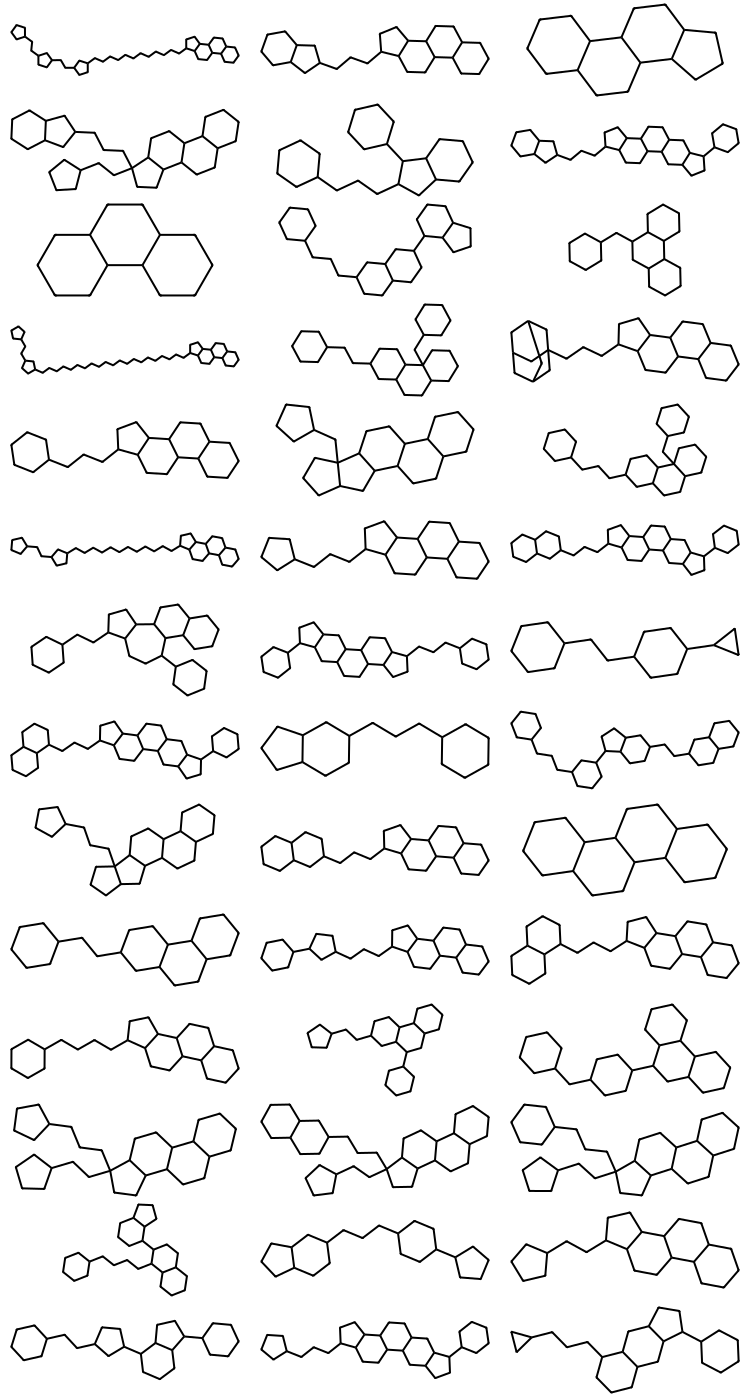

In [107]:
IPythonConsole.drawOptions.drawMolsSameScale=False
mol = [Chem.MolFromSmiles(x) for x in data_clusters_glucocor[\
                                data_clusters_glucocor['clusters']==0]['scaffolds_csk']]
Draw.MolsToGridImage(mol,molsPerRow=3,subImgSize=(250, 100))

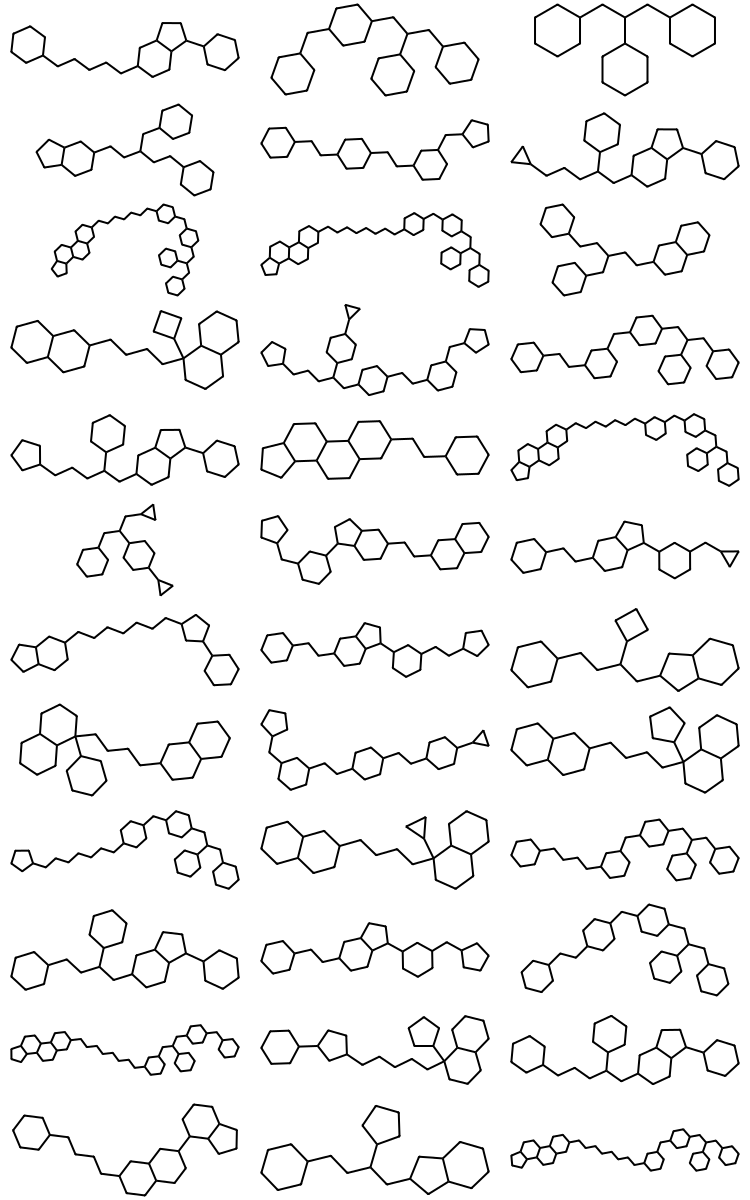

In [108]:
IPythonConsole.drawOptions.drawMolsSameScale=False
mol = [Chem.MolFromSmiles(x) for x in data_clusters_glucocor[\
                                data_clusters_glucocor['clusters']==1]['scaffolds_csk']]
Draw.MolsToGridImage(mol,molsPerRow=3,subImgSize=(250, 100))

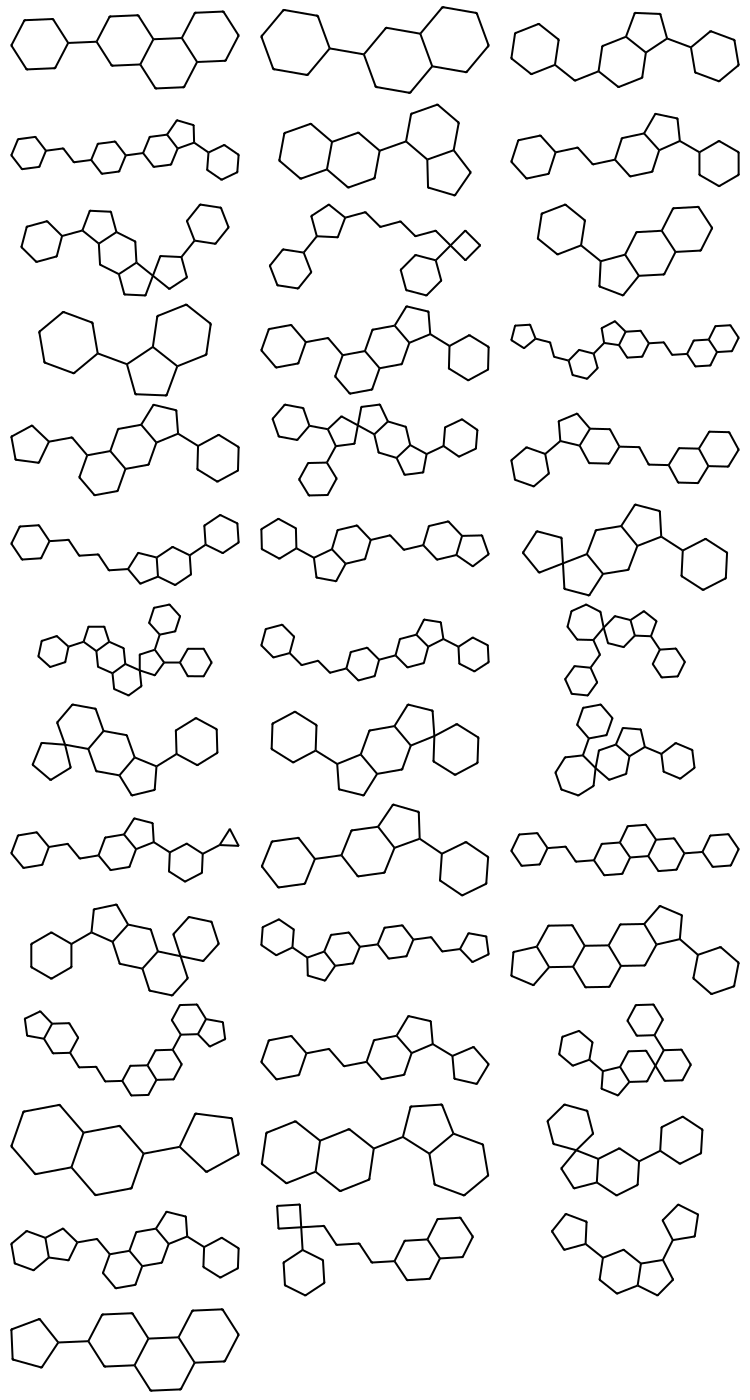

In [109]:
IPythonConsole.drawOptions.drawMolsSameScale=False
mol = [Chem.MolFromSmiles(x) for x in data_clusters_glucocor[\
                                data_clusters_glucocor['clusters']==3]['scaffolds_csk']]
Draw.MolsToGridImage(mol,molsPerRow=3,subImgSize=(250, 100))

In [14]:
df = pd.read_csv("data/input_data/input_gener_glucocor_dis_0.csv", header = None)
df

,0
0,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)COc2ccc3c(cnn3-c3...
1,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...
2,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...
3,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...
4,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...
...,...
949,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cc(C)cc3c2cnn...
950,CC(C)(CC(O)(CCc1ccccc1)C(=O)Nc1ccc2c(c1)COC2=O...
951,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...
952,Cc1c[nH]c2c(-c3c(F)cc4c(c3F)/C(=N/Oc3ccccc3)CC...


In [17]:
len(df[0].unique())

952

In [31]:
df = dff

In [33]:
a = []
for x in df['smiles']:
    if x in a:
        print(x)
    else:
        a.append(x)
    

C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21
N#Cc1cc(C(O)(c2ccc3c(cnn3-c3ccc(F)cc3)c2)C(F)(F)F)ccc1F


In [34]:
df[df['smiles']=='C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21']

,id,smiles,p_chembl
347,347,C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21,7.47
348,348,C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21,7.40


In [47]:
nuclear_glucocor[nuclear_glucocor['canonical_smiles']=='C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21']

,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp
6,553296,IC50,7.40,40.0,C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21,YKAWXLKLBCDEQW-UHFFFAOYSA-N,CHEMBL541908,25,Glucocorticoid receptor,C1CCC(C2CCC3CCCCC3C2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
760,386035,IC50,7.47,34.0,C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21,SSAMEZHVGWGDGH-UHFFFAOYSA-N,CHEMBL395506,25,Glucocorticoid receptor,C1CCC(C2CCC3CCCCC3C2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
df = pd.read_csv("../../../postgres/chembl_data/sets/nuclear_threshold_100nM_new/25_pic50.csv", header = None)
df.columns =['molregno', 'stand_type', 
                                    'pchembl_value', 'stand_value',
                                    'canonical_smiles', 'stand_inchi',
                                   'chembl_id', 'tid','pref_name']

In [42]:
df

,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name
0,72705,IC50,7.40,40.0,COc1cccc2c1-c1ccc3c(c1[C@H]([C@H]1C=C(C)CCC1)O...,ZOUVODOOOFQPOC-DWXRJYCRSA-N,CHEMBL46325,25,Glucocorticoid receptor
1,72755,IC50,7.92,12.0,COc1cccc2c1-c1ccc3c(c1C(C1C=CCC1)O2)C(C)=CC(C)...,BDZQBRNZPXXVRN-UHFFFAOYSA-N,CHEMBL47463,25,Glucocorticoid receptor
2,72017,IC50,7.12,76.0,COc1cccc2c1-c1ccc3c(c1C(CC=C(F)F)O2)C(C)=CC(C)...,MACROYAVMFWALR-UHFFFAOYSA-N,CHEMBL50118,25,Glucocorticoid receptor
3,72739,IC50,7.82,15.0,COc1cccc2c1-c1ccc3c(c1C(C1C=C(C)CCC1)O2)C(C)=C...,ZOUVODOOOFQPOC-UHFFFAOYSA-N,CHEMBL48588,25,Glucocorticoid receptor
4,71997,IC50,7.89,13.0,COc1cccc2c1-c1ccc3c(c1C(C1C=CCCC1)O2)C(C)=CC(C...,OSLBGHLVIZGEEN-UHFFFAOYSA-N,CHEMBL46199,25,Glucocorticoid receptor
...,...,...,...,...,...,...,...,...,...
1858,2517273,IC50,7.05,90.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@@H]3CCCN(C(=O)[C...,IHSJODAUGPFFCM-BWWCKNBVSA-N,CHEMBL4780682,25,Glucocorticoid receptor
1859,2514528,IC50,8.15,7.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@H]3CCCN(C(=O)[C@...,IHSJODAUGPFFCM-FJYDYCOSSA-N,CHEMBL4777937,25,Glucocorticoid receptor
1860,2502352,IC50,8.05,9.0,Cc1ccc([C@@H](Oc2ccc(C(=O)NC3CCCCC3)nc2)[C@H](...,LZNNVIVDLGFSQD-KKSFZXQISA-N,CHEMBL4755015,25,Glucocorticoid receptor
1861,2515140,IC50,7.58,26.0,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,KJELVKWMZHVGSD-KKSFZXQISA-N,CHEMBL4778549,25,Glucocorticoid receptor


In [63]:
compounds = []
df['pchembl_value_mean'] = [float(0) for x in range(len(df))]
df['pchembl_value_median'] = [float(0) for x in range(len(df))]
df['pchembl_value_diference'] = [float(0) for x in range(len(df))]
for x in range(len(df)):
    #print(df.loc[x]['stand_inchi'])
    if df.loc[x]['stand_inchi'] not in compounds:
        compounds.append(df.loc[x]['stand_inchi'])
        df['pchembl_value_mean'][x] = float(df.loc[x]['pchembl_value'])
        df['pchembl_value_median'][x] = float(df.loc[x]['pchembl_value'])
        df['pchembl_value_diference'][x] = float(df.loc[x]['pchembl_value'] - df.loc[x]['pchembl_value'])
    else:
        print("ELSE")
        inchi = df.loc[x]['stand_inchi']
        a = df[df['stand_inchi']==inchi]
        print(a.pchembl_value)
        m = []
        for y in a.pchembl_value:
            m.append(y)
        n = np.array(m)
        df['pchembl_value_mean'][x] = float(n.mean())
        df['pchembl_value_median'][x] = float(np.median(n))
        df['pchembl_value_diference'][x] = float(n.mean() - np.median(n))
        print(df.loc[x])
        

/tmp/ipykernel_15875/22604707.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pchembl_value_mean'][x] = float(df.loc[x]['pchembl_value'])
/tmp/ipykernel_15875/22604707.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pchembl_value_median'][x] = float(df.loc[x]['pchembl_value'])
/tmp/ipykernel_15875/22604707.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pchembl_value_diference'][x] = float(df.loc[x]['pchembl_v

ELSE
7     7.85
9     7.48
22    8.16
25    7.89
Name: pchembl_value, dtype: float64
molregno                                                              3214
stand_type                                                            IC50
pchembl_value                                                         7.48
stand_value                                                           33.0
canonical_smiles           C=CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3
stand_inchi                                    CZSDJYXNNJQXBB-UHFFFAOYSA-N
chembl_id                                                     CHEMBL266282
tid                                                                     25
pref_name                                         Glucocorticoid receptor 
pchembl_value_mean                                                   7.845
pchembl_value_median                                                  7.87
pchembl_value_diference                                             -0.025
Name: 9, dtype:

molregno                                                              352865
stand_type                                                              IC50
pchembl_value                                                            7.4
stand_value                                                            39.81
canonical_smiles           Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3CCCc4c(Br)cccc43...
stand_inchi                                      GIVISDRWZOTJRD-UHFFFAOYSA-N
chembl_id                                                       CHEMBL212312
tid                                                                       25
pref_name                                           Glucocorticoid receptor 
pchembl_value_mean                                                      7.75
pchembl_value_median                                                     7.7
pchembl_value_diference                                                 0.05
Name: 336, dtype: object
ELSE
334    7.6
335    8.2
336    7.4
337    7.8
Na

molregno                                                              401038
stand_type                                                              IC50
pchembl_value                                                           8.18
stand_value                                                            6.607
canonical_smiles           CCC1(CC(O)(Cc2[nH]c3ccccc3c2C#N)C(F)(F)F)CCCc2...
stand_inchi                                      CUMVJZLXAHCFDC-UHFFFAOYSA-N
chembl_id                                                       CHEMBL391942
tid                                                                       25
pref_name                                           Glucocorticoid receptor 
pchembl_value_mean                                                  7.846667
pchembl_value_median                                                    8.12
pchembl_value_diference                                            -0.273333
Name: 589, dtype: object
ELSE
551    7.41
552    7.05
590    8.42
591    8.1

ELSE
878    7.6
879    7.6
880    7.8
907    7.7
908    7.4
909    7.4
Name: pchembl_value, dtype: float64
molregno                                                             1066654
stand_type                                                              IC50
pchembl_value                                                            7.6
stand_value                                                            25.12
canonical_smiles           Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cc(C)cc3c2cnn...
stand_inchi                                      OKEMHXYCVVXUPH-PMCHYTPCSA-N
chembl_id                                                      CHEMBL1668082
tid                                                                       25
pref_name                                           Glucocorticoid receptor 
pchembl_value_mean                                                  7.583333
pchembl_value_median                                                     7.6
pchembl_value_diference                       

molregno                                                             1275413
stand_type                                                              IC50
pchembl_value                                                            7.8
stand_value                                                             15.7
canonical_smiles           C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
stand_inchi                                      WNYLPFCKNQAAMB-PPUNREKOSA-N
chembl_id                                                      CHEMBL1940557
tid                                                                       25
pref_name                                           Glucocorticoid receptor 
pchembl_value_mean                                                       8.3
pchembl_value_median                                                     8.3
pchembl_value_diference                                                  0.0
Name: 1137, dtype: object
ELSE
1136    8.29
1138    7.09
Name: pchembl_value

molregno                                                             1746371
stand_type                                                              IC50
pchembl_value                                                           8.43
stand_value                                                              3.7
canonical_smiles           Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cccc3c2cnn3-c...
stand_inchi                                      VCQHAAIFVBBOLJ-IBGZPJMESA-N
chembl_id                                                      CHEMBL3261413
tid                                                                       25
pref_name                                           Glucocorticoid receptor 
pchembl_value_mean                                                  8.263333
pchembl_value_median                                                    8.43
pchembl_value_diference                                            -0.166667
Name: 1410, dtype: object
ELSE
1365    8.41
1388    7.92
1411    8.35
Name: 

molregno                                                             2238108
stand_type                                                              IC50
pchembl_value                                                            8.3
stand_value                                                              5.0
canonical_smiles           C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...
stand_inchi                                      QGKAPGNLHFHCIB-HCNQIRLPSA-N
chembl_id                                                      CHEMBL4098197
tid                                                                       25
pref_name                                           Glucocorticoid receptor 
pchembl_value_mean                                                      8.46
pchembl_value_median                                                    8.46
pchembl_value_diference                                                  0.0
Name: 1669, dtype: object
ELSE
1529    8.88
1622    9.68
1670    8.85
Name: 

In [60]:
df


,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,pchembl_value_mean,pchembl_value_median,pchembl_value_diference
0,72705,IC50,7.40,40.0,COc1cccc2c1-c1ccc3c(c1[C@H]([C@H]1C=C(C)CCC1)O...,ZOUVODOOOFQPOC-DWXRJYCRSA-N,CHEMBL46325,25,Glucocorticoid receptor,7.40,7.40,0.0
1,72755,IC50,7.92,12.0,COc1cccc2c1-c1ccc3c(c1C(C1C=CCC1)O2)C(C)=CC(C)...,BDZQBRNZPXXVRN-UHFFFAOYSA-N,CHEMBL47463,25,Glucocorticoid receptor,7.92,7.92,0.0
2,72017,IC50,7.12,76.0,COc1cccc2c1-c1ccc3c(c1C(CC=C(F)F)O2)C(C)=CC(C)...,MACROYAVMFWALR-UHFFFAOYSA-N,CHEMBL50118,25,Glucocorticoid receptor,7.12,7.12,0.0
3,72739,IC50,7.82,15.0,COc1cccc2c1-c1ccc3c(c1C(C1C=C(C)CCC1)O2)C(C)=C...,ZOUVODOOOFQPOC-UHFFFAOYSA-N,CHEMBL48588,25,Glucocorticoid receptor,7.82,7.82,0.0
4,71997,IC50,7.89,13.0,COc1cccc2c1-c1ccc3c(c1C(C1C=CCCC1)O2)C(C)=CC(C...,OSLBGHLVIZGEEN-UHFFFAOYSA-N,CHEMBL46199,25,Glucocorticoid receptor,7.89,7.89,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1858,2517273,IC50,7.05,90.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@@H]3CCCN(C(=O)[C...,IHSJODAUGPFFCM-BWWCKNBVSA-N,CHEMBL4780682,25,Glucocorticoid receptor,0.00,0.00,0.0
1859,2514528,IC50,8.15,7.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@H]3CCCN(C(=O)[C@...,IHSJODAUGPFFCM-FJYDYCOSSA-N,CHEMBL4777937,25,Glucocorticoid receptor,0.00,0.00,0.0
1860,2502352,IC50,8.05,9.0,Cc1ccc([C@@H](Oc2ccc(C(=O)NC3CCCCC3)nc2)[C@H](...,LZNNVIVDLGFSQD-KKSFZXQISA-N,CHEMBL4755015,25,Glucocorticoid receptor,0.00,0.00,0.0
1861,2515140,IC50,7.58,26.0,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,KJELVKWMZHVGSD-KKSFZXQISA-N,CHEMBL4778549,25,Glucocorticoid receptor,0.00,0.00,0.0


In [74]:
df2 = df.drop_duplicates(subset=["stand_inchi"], keep='last')

In [75]:
df2

,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,pchembl_value_mean,pchembl_value_median,pchembl_value_diference
10,71774,IC50,7.42,38.0,C/C=C/CC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(...,BSJYFMFPTGYKFE-VOTSOKGWSA-N,CHEMBL47742,25,Glucocorticoid receptor,7.42,7.42,0.0
11,72705,IC50,7.72,19.0,COc1cccc2c1-c1ccc3c(c1[C@H]([C@H]1C=C(C)CCC1)O...,ZOUVODOOOFQPOC-DWXRJYCRSA-N,CHEMBL46325,25,Glucocorticoid receptor,7.56,7.56,0.0
12,72019,IC50,7.64,23.0,COc1cccc2c1-c1ccc3c(c1C(CC=C(C)C)O2)C(C)=CC(C)...,LDKWLXWPPRKXHO-UHFFFAOYSA-N,CHEMBL45720,25,Glucocorticoid receptor,7.64,7.64,0.0
13,72755,IC50,7.92,12.0,COc1cccc2c1-c1ccc3c(c1C(C1C=CCC1)O2)C(C)=CC(C)...,BDZQBRNZPXXVRN-UHFFFAOYSA-N,CHEMBL47463,25,Glucocorticoid receptor,7.92,7.92,0.0
15,72017,IC50,7.70,20.0,COc1cccc2c1-c1ccc3c(c1C(CC=C(F)F)O2)C(C)=CC(C)...,MACROYAVMFWALR-UHFFFAOYSA-N,CHEMBL50118,25,Glucocorticoid receptor,7.41,7.41,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1858,2517273,IC50,7.05,90.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@@H]3CCCN(C(=O)[C...,IHSJODAUGPFFCM-BWWCKNBVSA-N,CHEMBL4780682,25,Glucocorticoid receptor,7.05,7.05,0.0
1859,2514528,IC50,8.15,7.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@H]3CCCN(C(=O)[C@...,IHSJODAUGPFFCM-FJYDYCOSSA-N,CHEMBL4777937,25,Glucocorticoid receptor,8.15,8.15,0.0
1860,2502352,IC50,8.05,9.0,Cc1ccc([C@@H](Oc2ccc(C(=O)NC3CCCCC3)nc2)[C@H](...,LZNNVIVDLGFSQD-KKSFZXQISA-N,CHEMBL4755015,25,Glucocorticoid receptor,8.05,8.05,0.0
1861,2515140,IC50,7.58,26.0,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,KJELVKWMZHVGSD-KKSFZXQISA-N,CHEMBL4778549,25,Glucocorticoid receptor,7.58,7.58,0.0


In [76]:
df2[df2['pchembl_value_diference'] != 0]

,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,pchembl_value_mean,pchembl_value_median,pchembl_value_diference
25,3214,IC50,7.89,13.00,C=CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CZSDJYXNNJQXBB-UHFFFAOYSA-N,CHEMBL266282,25,Glucocorticoid receptor,7.845000,7.870,-0.025000
140,159550,IC50,7.75,18.00,COc1cccc2c1-c1ccc3c(c1C(c1cc(C)cc(C)c1)O2)C(C)...,BFFNEJBHCHAMGY-UHFFFAOYSA-N,CHEMBL330638,25,Glucocorticoid receptor,7.803333,7.750,0.053333
141,159368,IC50,7.75,18.00,COc1cccc2c1-c1ccc3c(c1C(c1cc(C)cc(Br)c1)O2)C(C...,JLRMPPDXUOKHKL-UHFFFAOYSA-N,CHEMBL100219,25,Glucocorticoid receptor,7.736667,7.750,-0.013333
142,159220,IC50,7.17,67.00,COc1cccc2c1-c1ccc3c(c1C(c1cc(Cl)cc(Cl)c1)O2)C(...,UTLVNNNRCCRBDZ-UHFFFAOYSA-N,CHEMBL419158,25,Glucocorticoid receptor,7.953333,7.800,0.153333
143,159249,IC50,8.05,9.00,COc1cccc2c1-c1ccc3c(c1C(c1cc(F)cc(F)c1)O2)C(C)...,WDWACRBIIZCRGV-UHFFFAOYSA-N,CHEMBL99123,25,Glucocorticoid receptor,7.815000,7.980,-0.165000
...,...,...,...,...,...,...,...,...,...,...,...,...
1788,2286949,IC50,9.24,0.57,COc1ccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C...,GDLMXSZEDBKHNY-LOSJGSFVSA-N,CHEMBL4208798,25,Glucocorticoid receptor,8.050000,7.750,0.300000
1805,2285167,IC50,8.66,2.20,CC(C)[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-...,ROGXRBIZXSSLJN-LOSJGSFVSA-N,CHEMBL4207016,25,Glucocorticoid receptor,8.210000,8.330,-0.120000
1846,2266100,IC50,8.12,7.50,CN(C)c1ccc([C@H]2C[C@@]3(C)[C@@H](CC[C@@]3(O)C...,MKYOYWSMPLRHDW-SSKMXYOESA-N,CHEMBL4163069,25,Glucocorticoid receptor,8.020000,8.100,-0.080000
1847,2441483,IC50,7.80,16.00,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,LJUSMSPTDKGAFT-LMNHVJTASA-N,CHEMBL4571052,25,Glucocorticoid receptor,7.803333,7.800,0.003333


In [82]:
print("Max_value",df2.pchembl_value_diference.max())
print("Min_value",df2.pchembl_value_diference.min())

Max_value 0.3000000000000007
Min_value -0.6666666666666661


In [73]:
df[df['molregno']==3214]

,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,pchembl_value_mean,pchembl_value_median,pchembl_value_diference
7,3214,IC50,7.85,14.0,C=CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CZSDJYXNNJQXBB-UHFFFAOYSA-N,CHEMBL266282,25,Glucocorticoid receptor,7.850,7.85,0.000
9,3214,IC50,7.48,33.0,C=CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CZSDJYXNNJQXBB-UHFFFAOYSA-N,CHEMBL266282,25,Glucocorticoid receptor,7.845,7.87,-0.025
22,3214,IC50,8.16,6.9,C=CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CZSDJYXNNJQXBB-UHFFFAOYSA-N,CHEMBL266282,25,Glucocorticoid receptor,7.845,7.87,-0.025
25,3214,IC50,7.89,13.0,C=CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CZSDJYXNNJQXBB-UHFFFAOYSA-N,CHEMBL266282,25,Glucocorticoid receptor,7.845,7.87,-0.025


In [49]:
df = pd.read_csv("data/input_data/Glucocorticoid_receptor/input_test_glucocor_sim_4.csv", header = None)


In [50]:
a = []

for x in range(len(df)):
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(df.loc[x][0]))
    a.append(MurckoScaffoldSmiles(Chem.MolToSmiles(MakeScaffoldGeneric(Chem.MolFromSmiles(smiles)))))

dff = pd.DataFrame(data = a)
len(dff[0].unique())

40